# Cloud of words
And now for some interesing results. A cloud of words is an image generated with words, where the words are sometimes rotated, placed in different sizes, fonts, styles, etc.
I our case, the words we display belong to the comments we extracted, and the size of a word will be proportional to its frequency in the corpora.

It is of great importance to highlight that we didn't use the raw comments, nor is recommended to pass it directly into the WordCloud, since it could get cluttered with punctuation or stopwords ("the", "a", "very", "so", etc). WordCloud has an option to pass the corpus and a list of stowpords, that the library will remove, but we already performed this cleaning step.

**Note**: The cloud of words uses information from enriched files, more specifically from the `tokens_wo_stopwords` column generated in the notebook `02_2_enriched_columns.ipynb`.
If the enriched files don't exist, no information will be displayed, or it may fail.

In [1]:
from wordcloud import WordCloud
from collections import Counter
import matplotlib.pyplot as plt
from matplotlib.colors import ListedColormap
import polars as pl
import os
import sys
from tqdm import tqdm

sys.path.append(os.path.abspath(os.path.join(os.getcwd(), "..")))
import config
from paths import Paths

channel_paths = Paths(channel_handle=config.channel_handle)

Cloud of words has multiple ways of taking in the data:
1) One approach is to feed the comments directly, that is, to create a comments array and to append every comment to this array. But there is an issue with this approach, as the number of comments grow, this single variable can be very large so we go with option 2.
2) The second approach is to build a frequencies table for every word in the comments. This option has a counter for every word that appears in all the comments, naturally, more lightweight than option 1.

## Polars and lazy operations
We could choose to load all comments in a concatenated dataframe but for this occasion we will utilize a handy framework form the Polars library: Lazy execution.
In polars, a lazy operation is like declarative sintax to deal with data, and only will be executed when `.collect()` is called. Polars internally handles optimizations and may rearange the order of operations to execute our request as fast as possible.
Here we are using the lazy framework from polars to count every word in all the comments across all files.

In [2]:
def build_token_counter(files: list[str], column: str = "tokens_wo_stop") -> Counter:
    counter = Counter()

    for path in tqdm(files, desc="Building word frequencies"):
        # Load the token column lazily
        df = pl.read_parquet(path, columns=[column]).lazy()
        
        # Explode the list column (each token gets its own row)
        df_exploded = df.explode(column)

        # Drop nulls, just in case
        df_filtered = df_exploded.drop_nulls(column)

        # Count token frequencies
        token_counts = (
            df_filtered
            .group_by(column)
            .len()
            .rename({column: "token", "len": "count"})
            .collect()
        )

        # Update the global counter
        counter.update(dict(zip(token_counts["token"], token_counts["count"])))

    return counter

### Files list
Now what remains is to have the list of enriched files, and the `Paths` class already provides a handy method to list all the files for the current YouTube channel handle and all the available dates. (The enriched files have to exist in the `/data/processed/enriched/<your_file_name_here>` in order for the paths object to recognize the files correctly).

In [3]:
files = channel_paths.list_enriched_files()
counter = build_token_counter(files, column="tokens_wo_stop")

Building word frequencies: 100%|██████████| 8/8 [00:04<00:00,  1.69it/s]


In [4]:
# See some word counts, print top 10 words by count
counter.most_common(10)

[('like', 551317),
 ('people', 459447),
 ('would', 459312),
 ('video', 456796),
 ('one', 355560),
 ('know', 277990),
 ('even', 271241),
 ('time', 268666),
 ('get', 260505),
 ('think', 258858)]

In [8]:
# Word count basic statistics
print(f'There are a total of {len(counter.keys()):_} distinct words, and {sum(counter.values()):_} words in total.')

There are a total of 800_849 distinct words, and 59_864_371 words in total.


Once the counter is complete, we proceed to generate our precious cloud of words.

# Cloud of words from WordCloud
The library we will be using is `WordCloud`, a handy and customizable library to generate cloud of words, you can choose the font, the colors, the size, etc.

In [5]:
def make_word_cloud_from_freq(frequencies, **kwargs):
    wordcloud = WordCloud(**kwargs).generate_from_frequencies(frequencies)
    plt.figure(figsize = (12,12))
    plt.imshow(wordcloud, interpolation = 'bilinear')
    plt.axis('off')
    plt.show()

#### Some important configurations to give more of a Kurzgesagt (kind of...) style

In [ ]:
# Custom colormap
colors = ["#FBBE00", "#E30050", "#E32E01", "#FFFFFF", "#FF7F50"]
background_color = "#0B0F33"
cmap = ListedColormap(colors)

params = dict(
    font_path = os.path.join('..', 'assets', 'Montserrat-Regular.ttf'), # Custom font
    width = 1000,
    height = 1000,
    max_font_size = 150,
    max_words = 100,
    background_color = background_color,
    colormap = cmap,
    contour_width = 0
    )

# And now, magic...

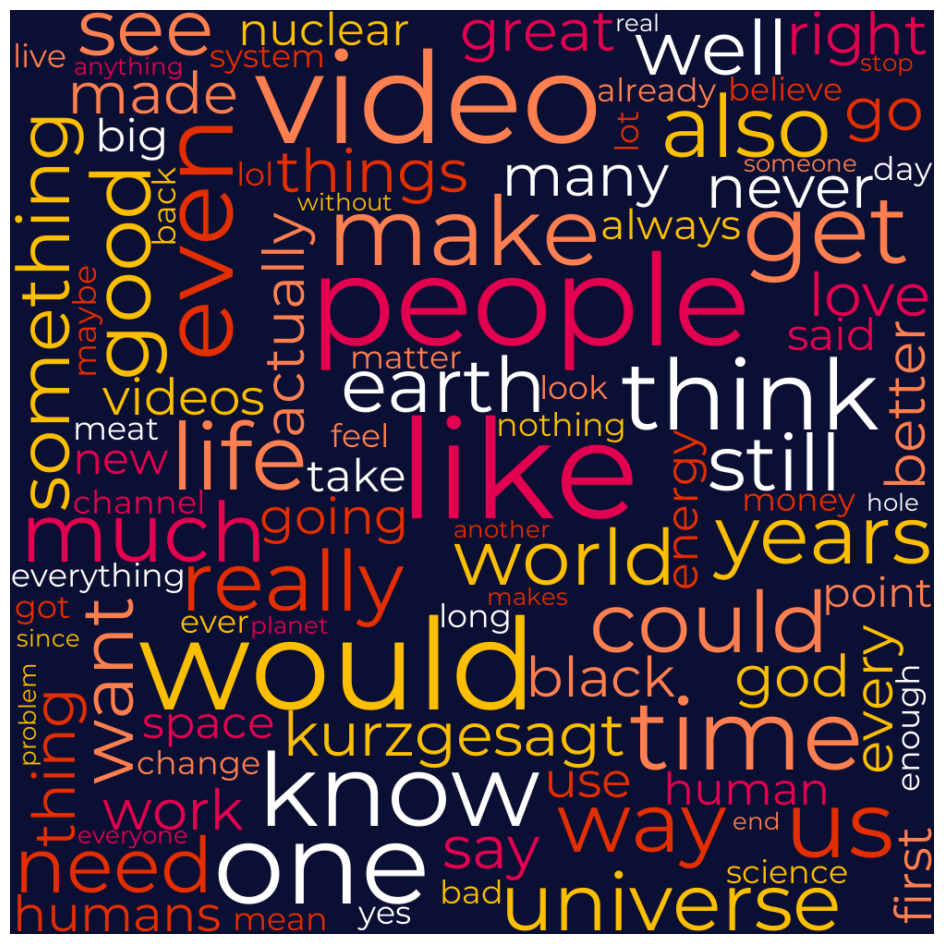

In [9]:
make_word_cloud_from_freq(counter, **params)

## (Optional) Word Cloud with korean script.
In our clean file we created a `script` column, that for now stores only `latin` and `korean`. Let's watch the most representative words by comments in Korean.

We start by loading the comment_id (so we may join later with the enriched file, since the `tokens_wo_stopwords` doesn't exist in the clean file, and the script doesn't exist in the enriched file)

In [11]:
def load_comment_script_map(clean_files: list[str]) -> pl.LazyFrame:
    return pl.concat([
        pl.read_parquet(file, columns=["comment_id", "script"])
        for file in clean_files
    ]).lazy()

Heavy lifting, load files, joins them with the script dataframe, filters korean, and counts the words for us.

In [12]:
def build_token_counter_by_joined_script(
    enriched_files: list[str],
    clean_files: list[str],
    column: str = "tokens_wo_stopwords",
    script_filter: str = "ko"
) -> Counter:
    counter = Counter()

    # Load all comment_id + script mapping
    script_map = load_comment_script_map(clean_files)

    for path in tqdm(enriched_files, desc=f"Counting tokens with script='{script_filter}'"):
        # Load the token column and comment_id from enriched file
        lf = pl.read_parquet(path, columns=["comment_id", column]).lazy()

        # Join with script map
        joined = (
            lf.join(script_map, on="comment_id", how="inner")
            .filter(pl.col("script") == script_filter)
            .explode(column)
            .drop_nulls(column)
            .group_by(column)
            .len()
            .rename({column: "token", "len": "count"})
            .collect()
        )

        counter.update(dict(zip(joined["token"], joined["count"])))

    return counter

In [14]:
enriched_files = channel_paths.list_enriched_files()
clean_files = channel_paths.list_processed_files()

counter_ko = build_token_counter_by_joined_script(
    enriched_files,
    clean_files,
    column="tokens_wo_stop",
    script_filter="korean"
)

# Print most common words
print(counter_ko.most_common(10))

Counting tokens with script='korean': 100%|██████████| 8/8 [00:01<00:00,  4.05it/s]

[('한국', 1624), ('ㅋㅋ', 1538), ('한국은', 1421), ('있는', 1266), ('그냥', 1141), ('너무', 1099), ('이미', 1063), ('한국의', 1048), ('진짜', 1041), ('있습니다', 1007)]


In [57]:
print(f'There are a total of {len(counter_ko.keys()):_} distinct words, and {sum(counter_ko.values()):_} words in total.')

There are a total of 124_376 distinct words, and 480_301 words in total.


# Korean Word Cloud

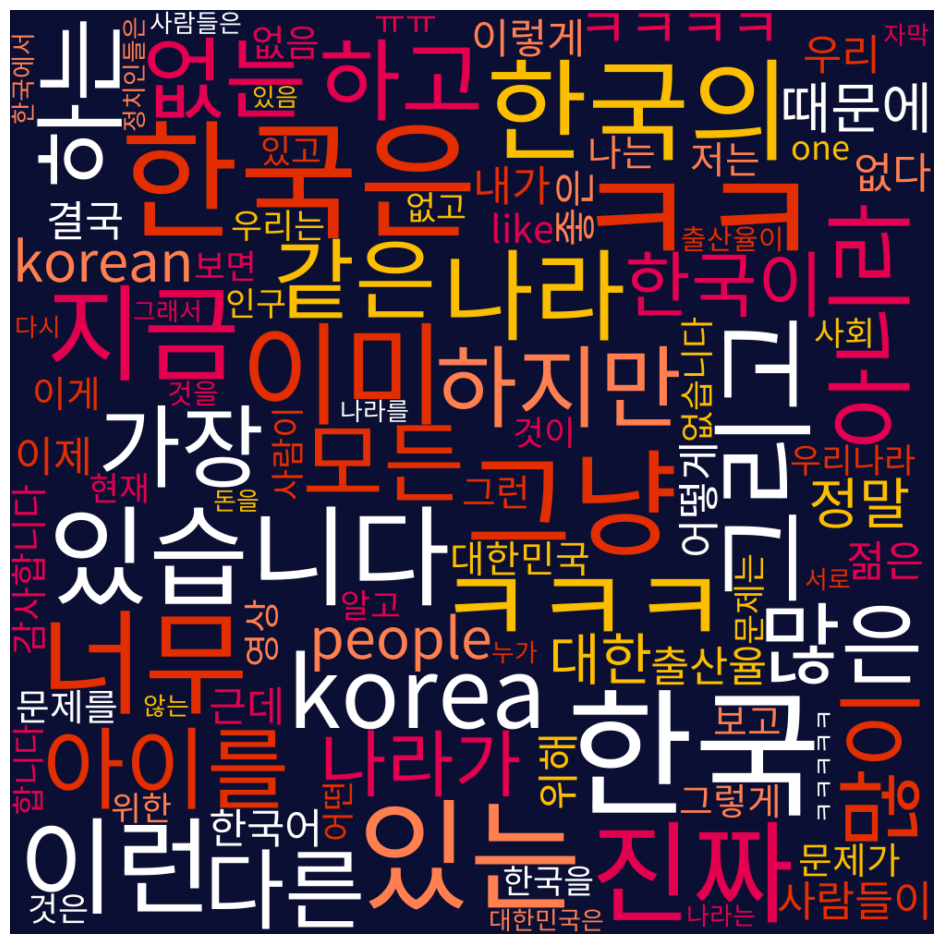

In [15]:
params['font_path'] = os.path.join('..', 'assets', 'NotoSansKR-Regular.ttf')
make_word_cloud_from_freq(counter_ko, **params)